# Turning any CNN image classifier into an object detector with Keras, TensorFlow, and OpenCV

## Image classification vs. object detection

When performing image classification, given an input image, we present it to our neural network, and we obtain a single class label and a probability associated with the class label prediction (Figure 1, left).

This class label is meant to characterize the contents of the entire image, or at least the most dominant, visible contents of the image.

We can thus think of image classification as:

* One image in
* One class label out

Object detection, on the other hand, not only tells us what is in the image (i.e., class label) but also where in the image the object is via bounding box (x, y)-coordinates (Figure 1, right).

Therefore, object detection algorithms allow us to:

* Input one image
* Obtain multiple bounding boxes and class labels as output

At the very core, any object detection algorithm (regardless of traditional computer vision or state-of-the-art deep learning), follows the same pattern:

* 1. Input: An image that we wish to apply object detection to
* 2. Output: Three values, including:
    * 2a. A list of bounding boxes, or the (x, y)-coordinates for each object in an image
    * 2b. The class label associated with each of the bounding boxes
    * 2c. The probability/confidence score associated with each bounding box and class label



 ## How can we turn any deep learning image classifier into an object detector?

That said, there is a hack we can leverage to turn our CNN image classifier into an object detector — and the secret sauce lies in traditional computer vision algorithms.

Back before deep learning-based object detectors, the state-of-the-art was to use HOG + Linear SVM to detect objects in an image.

We’ll be borrowing elements from HOG + Linear SVM to convert any deep neural network image classifier into an object detector.

**The first key ingredient from HOG + Linear SVM is to use image pyramids.**

An “image pyramid” is a multi-scale representation of an image:
<image src="images/keras_classifier_object_detector_pyramid_example_2.png">

Utilizing an image pyramid allows us to find objects in images at different scales (i.e., sizes) of an image (Figure 2).

At the bottom of the pyramid, we have the original image at its original size (in terms of width and height).

And at each subsequent layer, the image is resized (subsampled) and optionally smoothed (usually via Gaussian blurring).

The image is progressively subsampled until some stopping criterion is met, which is normally when a minimum size has been reached and no further subsampling needs to take place.

**The second key ingredient we need is sliding windows:***
As the name suggests, a sliding window is a fixed-size rectangle that slides from left-to-right and top-to-bottom within an image. (As Figure 3 demonstrates, our sliding window could be used to detect the face in the input image).

At each stop of the window we would:

1. Extract the ROI
2. Pass it through our image classifier (ex., Linear SVM, CNN, etc.)
3. Obtain the output predictions

Combined with image pyramids, sliding windows allow us to localize objects at different locations and multiple scales of the input image.

**The final key ingredient we need is non-maxima suppression.**

When performing object detection, our object detector will typically produce multiple, overlapping bounding boxes surrounding an object in an image.

## Combining traditional computer vision with deep learning to build an object detector
<image src="images/keras_classifier_object_detector_steps.png">


In order to take any Convolutional Neural Network trained for image classification and instead utilize it for object detection, we’re going to utilize the three key ingredients for traditional computer vision:

1. Image pyramids: Localize objects at different scales/sizes.
2. Sliding windows: Detect exactly where in the image a given object is.
3. Non-maxima suppression: Collapse weak, overlapping bounding boxes.

The general flow of our algorithm will be:

* Step #1: Input an image
* Step #2: Construct an image pyramid
* Step #3: For each scale of the image pyramid, run a sliding window
    * Step #3a: For each stop of the sliding window, extract the ROI
    * Step #3b: Take the ROI and pass it through our CNN originally trained for image classification
    * Step #3c: Examine the probability of the top class label of the CNN, and if meets a minimum confidence, record (1) the class label and (2) the location of the sliding window
* Step #4: Apply class-wise non-maxima suppression to the bounding boxes
* Step #5: Return results to calling function

That may seem like a complicated process, but as you’ll see in the remainder of this post, we can implement the entire object detection procedure in < 200 lines of code!

### Import Packages

In [1]:
# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
from matplotlib import pyplot as plt
import numpy as np
import argparse
import imutils
import random
import time
import cv2

### Function to display images in Jupyter Notebooks and Google Colab

In [2]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Implementing our image pyramid and sliding window utility functions

In [3]:
def sliding_window(image, step, ws):
	# slide a window across the image
	for y in range(0, image.shape[0] - ws[1], step):
		for x in range(0, image.shape[1] - ws[0], step):
			# yield the current window
			yield (x, y, image[y:y + ws[1], x:x + ws[0]])

In [4]:
def image_pyramid(image, scale=1.5, minSize=(224, 224)):
	# yield the original image
	yield image

	# keep looping over the image pyramid
	while True:
		# compute the dimensions of the next image in the pyramid
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)

		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break

		# yield the next image in the pyramid
		yield image

### Using Keras and TensorFlow to turn a pre-trained image classifier into an object detector

In [5]:
# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", required=True,
#	help="path to the input image")
#ap.add_argument("-s", "--size", type=str, default="(200, 150)",
#	help="ROI size (in pixels)")
#ap.add_argument("-c", "--min-conf", type=float, default=0.9,
#	help="minimum probability to filter weak detections")
#ap.add_argument("-v", "--visualize", type=int, default=-1,
#	help="whether or not to show extra visualizations for debugging")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "data/stingray.jpg",
	"size": "(300, 150)",
	"min_conf": 0.9, #increase to remove false-positive predictions
	"visualize": -1
}

In [6]:
# initialize variables used for the object detection procedure
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 16
ROI_SIZE = eval(args["size"])
INPUT_SIZE = (224, 224)

In [7]:
# load our network weights from disk
print("[INFO] loading network...")
model = ResNet50(weights="imagenet", include_top=True)

# load the input image from disk, resize it such that it has the
# has the supplied width, and then grab its dimensions
orig = cv2.imread(args["image"])
orig = imutils.resize(orig, width=WIDTH)
(H, W) = orig.shape[:2]

[INFO] loading network...


In [8]:
# initialize the image pyramid
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=ROI_SIZE)

# initialize two lists, one to hold the ROIs generated from the image
# pyramid and sliding window, and another list used to store the
# (x, y)-coordinates of where the ROI was in the original image
rois = []
locs = []

# time how long it takes to loop over the image pyramid layers and
# sliding window locations
start = time.time()

In [9]:
# loop over the image pyramid
for image in pyramid:
	# determine the scale factor between the *original* image
	# dimensions and the *current* layer of the pyramid
	scale = W / float(image.shape[1])

	# for each layer of the image pyramid, loop over the sliding
	# window locations
	for (x, y, roiOrig) in sliding_window(image, WIN_STEP, ROI_SIZE):
		# scale the (x, y)-coordinates of the ROI with respect to the
		# *original* image dimensions
		x = int(x * scale)
		y = int(y * scale)
		w = int(ROI_SIZE[0] * scale)
		h = int(ROI_SIZE[1] * scale)

		# take the ROI and preprocess it so we can later classify
		# the region using Keras/TensorFlow
		roi = cv2.resize(roiOrig, INPUT_SIZE)
		roi = img_to_array(roi)
		roi = preprocess_input(roi)

		# update our list of ROIs and associated coordinates
		rois.append(roi)
		locs.append((x, y, x + w, y + h))

        # check to see if we are visualizing each of the sliding
		# windows in the image pyramid
		if args["visualize"] > 0:
			# clone the original image and then draw a bounding box
			# surrounding the current region
			clone = orig.copy()
			cv2.rectangle(clone, (x, y), (x + w, y + h),
				(0, 255, 0), 2)

			# show the visualization and current ROI
			plt_imshow("Visualization", clone)
			plt_imshow("ROI", roiOrig)

In [10]:
# show how long it took to loop over the image pyramid layers and
# sliding window locations
end = time.time()
print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(
	end - start))

# convert the ROIs to a NumPy array
rois = np.array(rois, dtype="float32")

# classify each of the proposal ROIs using ResNet and then show how
# long the classifications took
print("[INFO] classifying ROIs...")
start = time.time()
preds = model.predict(rois)
end = time.time()
print("[INFO] classifying ROIs took {:.5f} seconds".format(end - start))

# decode the predictions and initialize a dictionary which maps class
# labels (keys) to any ROIs associated with that label (values)
preds = imagenet_utils.decode_predictions(preds, top=1)
labels = {}

[INFO] looping over pyramid/windows took 0.90793 seconds
[INFO] classifying ROIs...
[INFO] classifying ROIs took 141.99353 seconds


In [11]:
# loop over the predictions
for (i, p) in enumerate(preds):
	# grab the prediction information for the current ROI
	(imagenetID, label, prob) = p[0]

	# filter out weak detections by ensuring the predicted probability
	# is greater than the minimum probability
	if prob >= args["min_conf"]:
		# grab the bounding box associated with the prediction and
		# convert the coordinates
		box = locs[i]

		# grab the list of predictions for the label and add the
		# bounding box and probability to the list
		L = labels.get(label, [])
		L.append((box, prob))
		labels[label] = L

[INFO] showing results for 'stingray'


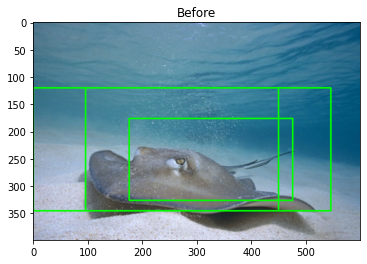

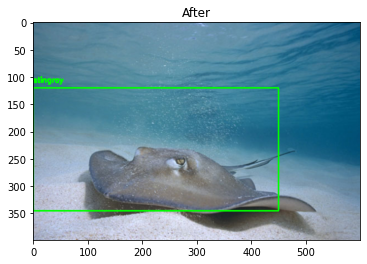

In [12]:
# loop over the labels for each of detected objects in the image
for label in labels.keys():
	# clone the original image so that we can draw on it
	print("[INFO] showing results for '{}'".format(label))
	clone = orig.copy()

	# loop over all bounding boxes for the current label
	for (box, prob) in labels[label]:
		# draw the bounding box on the image
		(startX, startY, endX, endY) = box
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)

	# show the results *before* applying non-maxima suppression, then
	# clone the image again so we can display the results *after*
	# applying non-maxima suppression
	plt_imshow("Before", clone)
	clone = orig.copy()

    # extract the bounding boxes and associated prediction
	# probabilities, then apply non-maxima suppression
	boxes = np.array([p[0] for p in labels[label]])
	proba = np.array([p[1] for p in labels[label]])
	boxes = non_max_suppression(boxes, proba)

	# loop over all bounding boxes that were kept after applying
	# non-maxima suppression
	for (startX, startY, endX, endY) in boxes:
		# draw the bounding box and label on the image
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.putText(clone, label, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

	# show the output after apply non-maxima suppression
	plt_imshow("After", clone)

# OpenCV Selective Search for Object Detection

Selective Search, first introduced by Uijlings et al. in their 2012 paper, [Selective Search for Object Recognition](http://www.huppelen.nl/publications/selectiveSearchDraft.pdf), is a critical piece of computer vision, deep learning, and object detection research.

In their work, Uijlings et al. demonstrated:

1. How images can be over-segmented to automatically identify locations in an image that could contain an object
2. That Selective Search is far more computationally efficient than exhaustively computing image pyramids and sliding windows (and without loss of accuracy)
3. And that Selective Search can be swapped in for any object detection framework that utilizes image pyramids and sliding windows

From there, we’ll review the Selective Search algorithm in detail, including how it over-segments an image via:

1. Color similarity
2. Texture similarity
3. Size similarity
4. Shape similarity
5. A final meta-similarity, which is a linear combination of the above similarity measures

## Region proposals versus sliding windows and image pyramids

a region proposal algorithm should inspect the image and attempt to find regions of an image that likely contain an object (think of region proposal as a cousin to [saliency detection](https://www.pyimagesearch.com/2018/07/16/opencv-saliency-detection/)).

The region proposal algorithm should:

1. Be faster and more efficient than sliding windows and image pyramids
2. Accurately detect the regions of an image that could contain an object
3. Pass these “candidate proposals” to a downstream classifier to actually label the regions, thus completing the object detection framework

## What is Selective Search and how can Selective Search be used for object detection?

Selective Search works by over-segmenting an image using a superpixel algorithm (instead of SLIC, Uijlings et al. use the Felzenszwalb method from Felzenszwalb and Huttenlocher’s 2004 paper, Efficient graph-based image segmentation).

An example of running the Felzenszwalb superpixel algorithm can be seen below:

<image src="images/opencv_selective_search_superpixel_segmentation.png">

Figure 2: OpenCV’s Selective Search uses the Felzenszwalb superpixel method to find regions of an image that could contain an object. Selective Search is not end-to-end object detection.

From there, Selective Search seeks to merge together the superpixels to find regions of an image that could contain an object.

Selective Search merges superpixels in a hierarchical fashion based on five key similarity measures:

1. Color similarity: Computing a 25-bin histogram for each channel of an image, concatenating them together, and obtaining a final descriptor that is 25×3=75-d. Color similarity of any two regions is measured by the histogram intersection distance.
2. Texture similarity: For texture, Selective Search extracts Gaussian derivatives at 8 orientations per channel (assuming a 3-channel image). These orientations are used to compute a 10-bin histogram per channel, generating a final texture descriptor that is 8x10x=240-d. To compute texture similarity between any two regions, histogram intersection is once again used.
3. Size similarity: The size similarity metric that Selective Search uses prefers that smaller regions be grouped earlier rather than later. Anyone who has used Hierarchical Agglomerative Clustering (HAC) algorithms before knows that HACs are prone to clusters reaching a critical mass and then combining everything that they touch. By enforcing smaller regions to merge earlier, we can help prevent a large number of clusters from swallowing up all smaller regions.
4. Shape similarity/compatibility: The idea behind shape similarity in Selective Search is that they should be compatible with each other. Two regions are considered “compatible” if they “fit” into each other (thereby filling gaps in our regional proposal generation). Furthermore, shapes that do not touch should not be merged.
5. A final meta-similarity measure: A final meta-similarity acts as a linear combination of the color similarity, texture similarity, size similarity, and shape similarity/compatibility.

The results of Selective Search applying these hierarchical similarity measures can be seen in the following figure:

<image src="images/opencv_selective_search_hierarchical.png">

On the bottom layer of the pyramid, we can see the original over-segmentation/superpixel generation from the Felzenszwalb method.

In the middle layer, we can see regions being joined together, eventually forming the final set of proposals (top).

If you’re interested in learning more about the underlying theory of Selective Search, I would suggest referring to the following resources:

* Efficient Graph-Based Image Segmentation (Felzenszwalb and Huttenlocher, 2004)
* Selective Search for Object Recognition (Uijlings et al., 2012)
* Selective Search for Object Detection (C++/Python) (Chandel/Mallick, 2017)


## Selective Search generates regions, not class labels
So, here’s the deal:

1. Selective Search does generate regions of an image that could contain an object.
2. However, Selective Search does not have any knowledge of what is in that region (think of it as a cousin to saliency detection).
3. Selective Search is meant to replace the computationally expensive, highly inefficient method of exhaustively using image pyramids and sliding windows to examine locations of an image for a potential object.
4. By using Selective Search, we can more efficiently examine regions of an image that likely contain an object and then pass those regions on to a SVM, CNN, etc. for final classification.

### Implementing Selective Search with OpenCV and Python

In [13]:
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", required=True,
#	help="path to the input image")
#ap.add_argument("-m", "--method", type=str, default="fast",
#	choices=["fast", "quality"],
#	help="selective search method")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "data/dog.jpg",
	"method": "fast" # "fast" "quality"
}

In [14]:
# load the input image
image = cv2.imread(args["image"])

# initialize OpenCV's selective search implementation and set the
# input image
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)

# check to see if we are using the *fast* but *less accurate* version
# of selective search
if args["method"] == "fast":
	print("[INFO] using *fast* selective search")
	ss.switchToSelectiveSearchFast()

# otherwise we are using the *slower* but *more accurate* version
else:
	print("[INFO] using *quality* selective search")
	ss.switchToSelectiveSearchQuality()

[INFO] using *fast* selective search


In [15]:
# run selective search on the input image
start = time.time()
rects = ss.process()
end = time.time()

# show how along selective search took to run along with the total
# number of returned region proposals
print("[INFO] selective search took {:.4f} seconds".format(end - start))
print("[INFO] {} total region proposals".format(len(rects)))

[INFO] selective search took 6.2454 seconds
[INFO] 1219 total region proposals


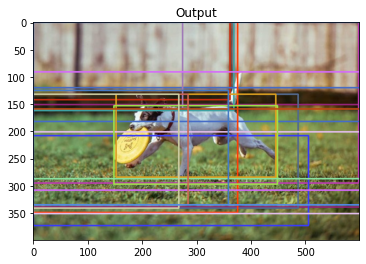

In [19]:
# loop over the region proposals in chunks (so we can better
# visualize them)
for i in range(0, len(rects), 100):
	# clone the original image so we can draw on it
	output = image.copy()

	# loop over the current subset of region proposals
	for (x, y, w, h) in rects[i:i + 100]:
		# draw the region proposal bounding box on the image
		color = [random.randint(0, 255) for j in range(0, 3)]
		cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)

# show the output image
plt_imshow("Output", output)

# Region proposal object detection with OpenCV, Keras, and TensorFlow
## What are region proposals, and how can they be used for object detection?
<image src="images/opencv_selective_search_hierarchical.png">

Region proposal algorithms seek to replace the traditional image pyramid and sliding window approach.

These algorithms:

1. Accept an input image
2. Over-segment it by applying a [superpixel clustering algorithm](https://www.pyimagesearch.com/tag/superpixel/)
3. Merge segments of the superpixels based on five components (color similarity, texture similarity, size similarity, shape similarity/compatibility, and a final meta-similarity that linearly combines the aforementioned scores)
The end results are proposals that indicate where in the image there could be an object.

### Implementing region proposal object detection with OpenCV, Keras, and TensorFlow

In [20]:
def selective_search(image, method="fast"):
	# initialize OpenCV's selective search implementation and set the
	# input image
	ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
	ss.setBaseImage(image)

	# check to see if we are using the *fast* but *less accurate* version
	# of selective search
	if method == "fast":
		ss.switchToSelectiveSearchFast()

	# otherwise we are using the *slower* but *more accurate* version
	else:
		ss.switchToSelectiveSearchQuality()

	# run selective search on the input image
	rects = ss.process()

	# return the region proposal bounding boxes
	return rects

In [29]:
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", required=True,
#	help="path to the input image")
#ap.add_argument("-m", "--method", type=str, default="fast",
#	choices=["fast", "quality"],
#	help="selective search method")
#ap.add_argument("-c", "--conf", type=float, default=0.9,
#	help="minimum probability to consider a classification/detection")
#ap.add_argument("-f", "--filter", type=str, default=None,
#	help="comma separated list of ImageNet labels to filter on")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "data/beagle.png",
	"method": "fast",
	"conf": 0.9,
	"filter": None # "beagle"
}

In [30]:
# grab the label filters command line argument
labelFilters = args["filter"]

# if the label filter is not empty, break it into a list
if labelFilters is not None:
	labelFilters = labelFilters.lower().split(",")

In [31]:
# load ResNet from disk (with weights pre-trained on ImageNet)
print("[INFO] loading ResNet...")
model = ResNet50(weights="imagenet")

# load the input image from disk and grab its dimensions
image = cv2.imread(args["image"])
(H, W) = image.shape[:2]

[INFO] loading ResNet...


In [32]:
# run selective search on the input image
print("[INFO] performing selective search with '{}' method...".format(
	args["method"]))
rects = selective_search(image, method=args["method"])
print("[INFO] {} regions found by selective search".format(len(rects)))

# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
proposals = []
boxes = []

[INFO] performing selective search with 'fast' method...
[INFO] 922 regions found by selective search


In [33]:
# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects:
	# if the width or height of the region is less than 10% of the
	# image width or height, ignore it (i.e., filter out small
	# objects that are likely false-positives)
	if w / float(W) < 0.1 or h / float(H) < 0.1:
		continue

	# extract the region from the input image, convert it from BGR to
	# RGB channel ordering, and then resize it to 224x224 (the input
	# dimensions required by our pre-trained CNN)
	roi = image[y:y + h, x:x + w]
	roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
	roi = cv2.resize(roi, (224, 224))

	# further preprocess by the ROI
	roi = img_to_array(roi)
	roi = preprocess_input(roi)

	# update our proposals and bounding boxes lists
	proposals.append(roi)
	boxes.append((x, y, w, h))

In [34]:
# convert the proposals list into NumPy array and show its dimensions
proposals = np.array(proposals)
print("[INFO] proposal shape: {}".format(proposals.shape))

# classify each of the proposal ROIs using ResNet and then decode the
# predictions
print("[INFO] classifying proposals...")
preds = model.predict(proposals)
preds = imagenet_utils.decode_predictions(preds, top=1)

# initialize a dictionary which maps class labels (keys) to any
# bounding box associated with that label (values)
labels = {}

[INFO] proposal shape: (534, 224, 224, 3)
[INFO] classifying proposals...


In [35]:
# loop over the predictions
for (i, p) in enumerate(preds):
	# grab the prediction information for the current region proposal
	(imagenetID, label, prob) = p[0]

	# only if the label filters are not empty *and* the label does not
	# exist in the list, then ignore it
	if labelFilters is not None and label not in labelFilters:
		continue

	# filter out weak detections by ensuring the predicted probability
	# is greater than the minimum probability
	if prob >= args["conf"]:
		# grab the bounding box associated with the prediction and
		# convert the coordinates
		(x, y, w, h) = boxes[i]
		box = (x, y, x + w, y + h)

		# grab the list of predictions for the label and add the
		# bounding box + probability to the list
		L = labels.get(label, [])
		L.append((box, prob))
		labels[label] = L

[INFO] showing results for 'beagle'


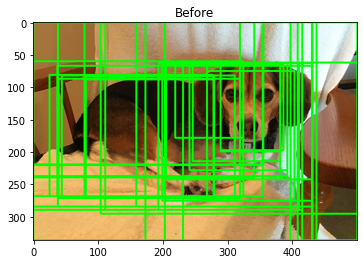

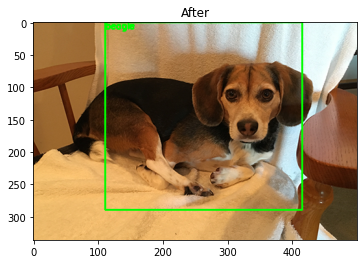

[INFO] showing results for 'quill'


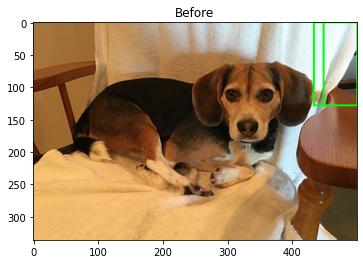

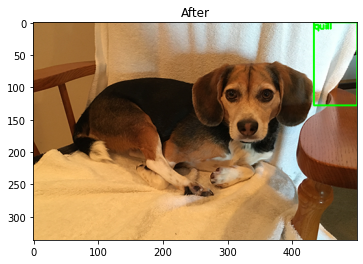

[INFO] showing results for 'clog'


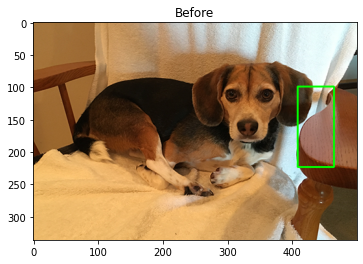

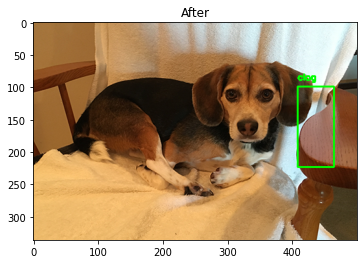

[INFO] showing results for 'paper_towel'


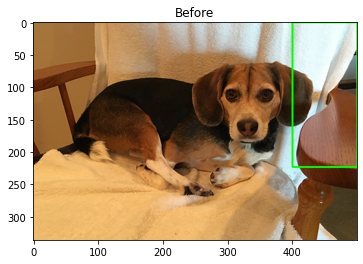

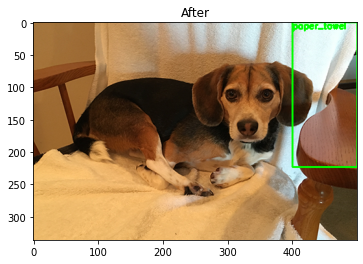

In [36]:
# loop over the labels for each of detected objects in the image
for label in labels.keys():
	# clone the original image so that we can draw on it
	print("[INFO] showing results for '{}'".format(label))
	clone = image.copy()

	# loop over all bounding boxes for the current label
	for (box, prob) in labels[label]:
		# draw the bounding box on the image
		(startX, startY, endX, endY) = box
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)

	# show the results *before* applying non-maxima suppression, then
	# clone the image again so we can display the results *after*
	# applying non-maxima suppression
	plt_imshow("Before", clone)
	clone = image.copy()

    # extract the bounding boxes and associated prediction
	# probabilities, then apply non-maxima suppression
	boxes = np.array([p[0] for p in labels[label]])
	proba = np.array([p[1] for p in labels[label]])
	boxes = non_max_suppression(boxes, proba)

	# loop over all bounding boxes that were kept after applying
	# non-maxima suppression
	for (startX, startY, endX, endY) in boxes:
		# draw the bounding box and label on the image
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.putText(clone, label, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

	# show the output after apply non-maxima suppression
	plt_imshow("After", clone)